<a href="https://colab.research.google.com/github/Liub-ov/data_analysis_2023/blob/main/Lab3_Peleshenko_FI32mn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import keras
from tensorflow.keras import layers
from keras import layers

from keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
import zipfile
import os
from collections import Counter



In [20]:
#Повнозв'язані нейронні мережі, fully connected feed-forward network

df = pd.read_csv('/content/sample_data/StressLevelDataset.csv')

fname = '/content/sample_data/StressLevelDataset.csv'

all_features = []
all_targets = []
with open(fname) as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue  # Skip header
        fields = line.strip().split(",")
        all_features.append([float(v.replace('"', "")) for v in fields[2:]])
        all_targets.append([int(fields[2].replace('"', ""))])
        if i == 1:
            print("EXAMPLE FEATURES:", all_features[-1])

features = np.array(all_features, dtype="float32")
targets = np.array(all_targets, dtype="uint8")
print("features.shape:", features.shape)
print("targets.shape:", targets.shape)

HEADER: anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,safety,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
EXAMPLE FEATURES: [0.0, 11.0, 2.0, 1.0, 2.0, 4.0, 2.0, 3.0, 3.0, 2.0, 3.0, 2.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 1.0]
features.shape: (1100, 19)
targets.shape: (1100, 1)


In [21]:
num_val_samples = int(len(features) * 0.2)
train_features = features[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_features = features[-num_val_samples:]
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_features))
print("Number of validation samples:", len(val_features))

Number of training samples: 880
Number of validation samples: 220


In [22]:
counts = np.bincount(train_targets[:, 0])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

Number of positive samples in training data: 436 (49.55% of total)


In [23]:
mean = np.mean(train_features, axis=0)
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std

In [24]:
import keras

model = keras.Sequential(
    [
        keras.Input(shape=train_features.shape[1:]),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               5120      
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 136961 (535.00 KB)
Trainable params: 136

In [25]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.keras")]
class_weight = {0: weight_for_0, 1: weight_for_1}

In [26]:
model.fit(
    train_features,
    train_targets,
    batch_size=2048,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(val_features, val_targets),
    class_weight=class_weight,
)

Epoch 1/30
1/1 - 2s - loss: 0.0016 - fn: 108.0000 - fp: 366.0000 - tn: 78.0000 - tp: 328.0000 - precision: 0.4726 - recall: 0.7523 - val_loss: 0.3222 - val_fn: 2.0000 - val_fp: 19.0000 - val_tn: 95.0000 - val_tp: 104.0000 - val_precision: 0.8455 - val_recall: 0.9811 - 2s/epoch - 2s/step
Epoch 2/30
1/1 - 0s - loss: 7.8333e-04 - fn: 16.0000 - fp: 75.0000 - tn: 369.0000 - tp: 420.0000 - precision: 0.8485 - recall: 0.9633 - val_loss: 0.1822 - val_fn: 5.0000 - val_fp: 9.0000 - val_tn: 105.0000 - val_tp: 101.0000 - val_precision: 0.9182 - val_recall: 0.9528 - 116ms/epoch - 116ms/step
Epoch 3/30
1/1 - 0s - loss: 4.8656e-04 - fn: 26.0000 - fp: 36.0000 - tn: 408.0000 - tp: 410.0000 - precision: 0.9193 - recall: 0.9404 - val_loss: 0.0880 - val_fn: 3.0000 - val_fp: 4.0000 - val_tn: 110.0000 - val_tp: 103.0000 - val_precision: 0.9626 - val_recall: 0.9717 - 125ms/epoch - 125ms/step
Epoch 4/30
1/1 - 0s - loss: 2.7194e-04 - fn: 19.0000 - fp: 12.0000 - tn: 432.0000 - tp: 417.0000 - precision: 0.9720 -

In [2]:
#Згорткові нейронні мережі

#Load the data
zip_ref = zipfile.ZipFile('/content/sample_data/pictures.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content/sample_data') #Extracts the files into the /tmp folder
zip_ref.close()

In [3]:
#Filter out corrupted images
num_skipped = 0
for folder_name in ("frost", "lightning", "rain", "rainbow", "sandstorm", "snow"):
    folder_path = os.path.join('/content/sample_data/dataset', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 132 images.


In [4]:
#Generate a Dataset
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    '/content/sample_data/dataset',
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2791 files belonging to 6 classes.
Using 2233 files for training.
Using 558 files for validation.


In [5]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
  ])

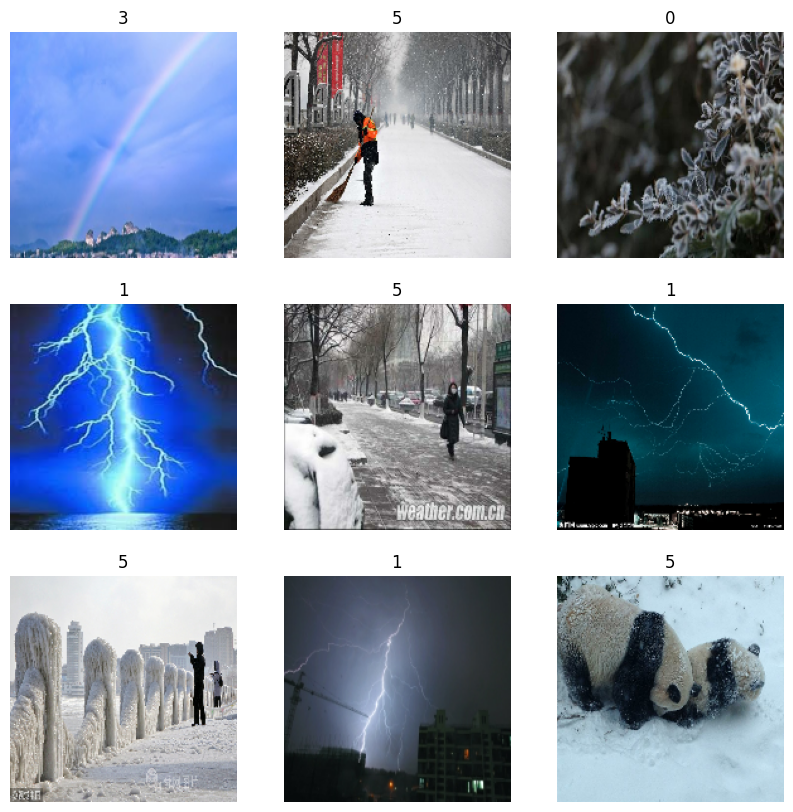

In [6]:
#Visualize the data, first 9 images in the training dataset.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
model_pic = keras.Sequential([
  data_augmentation,
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(64, 6, strides=2, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2D(128, 6, strides=2, padding='same', activation='tanh'),
  keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.6),
  keras.layers.Conv2D(256, 6, strides=2, padding='same', activation='tanh'),
  keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
  keras.layers.BatchNormalization(),
  keras.layers.Flatten(),
  keras.layers.Dense(256, activation='softmax'),
  keras.layers.Dense(6, name="outputs")
])


model_pic.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x788fe03c54e0>>

In [16]:
model_pic.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0002), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

model_pic.fit(train, validation_data = val_ds, epochs=10)

Epoch 1/10
18/18 [==============================] - 181s 8s/step - loss: 1.7299 - accuracy: 0.5213 - val_loss: 1.7893 - val_accuracy: 0.2330
Epoch 2/10
18/18 [==============================] - 128s 7s/step - loss: 1.6842 - accuracy: 0.5432 - val_loss: 1.7888 - val_accuracy: 0.2330
Epoch 3/10
18/18 [==============================] - 131s 7s/step - loss: 1.6736 - accuracy: 0.5387 - val_loss: 1.7875 - val_accuracy: 0.2401
Epoch 4/10
18/18 [==============================] - 132s 7s/step - loss: 1.6684 - accuracy: 0.5410 - val_loss: 1.7837 - val_accuracy: 0.2366
Epoch 5/10
18/18 [==============================] - 138s 8s/step - loss: 1.6624 - accuracy: 0.5392 - val_loss: 1.7819 - val_accuracy: 0.2491
Epoch 6/10
18/18 [==============================] - 130s 7s/step - loss: 1.6576 - accuracy: 0.5378 - val_loss: 1.7745 - val_accuracy: 0.2724
Epoch 7/10
18/18 [==============================] - 129s 7s/step - loss: 1.6519 - accuracy: 0.5419 - val_loss: 1.7621 - val_accuracy: 0.2599
Epoch 8/10
18

In [27]:
#Рекурентні нейронні мережі

dft = pd.read_csv('/content/sample_data/bbc-text.csv')
dft.columns

Index(['category', 'text'], dtype='object')

In [28]:
Counter(dft['category'])

Counter({'tech': 401,
         'business': 510,
         'sport': 511,
         'entertainment': 386,
         'politics': 417})

In [29]:
max_features = 20000
maxlen = 200

In [32]:
dft = dft.dropna(subset=['text'])

train_dft, val_dft = train_test_split(dft, test_size=0.2, random_state=42)

tokenizer = keras.preprocessing.text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_dft["text"])

x_train = tokenizer.texts_to_sequences(train_dft["text"])
x_val = tokenizer.texts_to_sequences(val_dft["text"])

x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

y_train = train_dft["category"].values
y_val = val_dft["category"].values

for i in range(len(y_train)):
  y_train[y_train=='tech']=1
  y_train[y_train=='business']=2
  y_train[y_train=='sport']=3
  y_train[y_train=='entertainment']=4
  y_train[y_train=='politics']=5

for i in range(len(y_train)):
  y_val[y_val=='tech']=1
  y_val[y_val=='business']=2
  y_val[y_val=='sport']=3
  y_val[y_val=='entertainment']=4
  y_val[y_val=='politics']=5

print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

1780 Training sequences
445 Validation sequences


In [33]:
y_train = np.asarray(y_train).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)

In [34]:
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2757761 (10.52 MB)
Trainable params: 2757761 (1

In [35]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=32, epochs=2, validation_data=(x_val, y_val))

Epoch 1/2
56/56 [==============================] - 43s 622ms/step - loss: -20.2653 - accuracy: 0.1770 - val_loss: -35.5526 - val_accuracy: 0.1843
Epoch 2/2
56/56 [==============================] - 36s 650ms/step - loss: -43.4428 - accuracy: 0.1792 - val_loss: -51.4224 - val_accuracy: 0.1843
